In [3]:
import sys
base_dir = "D:/Thesis/Cobra/cobra/"
if base_dir not in sys.path:
    sys.path.append(base_dir)
from os.path import join
import pandas as pd
import seaborn as sns
from utilities import basic, utils, mri_stats, stats
from stats_tools import vis as svis
import numpy as np
import seaborn as sns
from access_sif_data import load_data_tools as ld
import matplotlib.pyplot as plt
from datetime import datetime as dt
%matplotlib inline
plt.rcParams["figure.dpi"] = 40
plt.style.use('ggplot')
import importlib
importlib.reload(utils)

<module 'utilities.utils' from 'D:/Thesis/Cobra/cobra\\utilities\\utils.py'>

In [4]:
fig_dir = join(base_dir, 'figs')
table_dir = join(base_dir, 'data/tables')
dfc = utils.load_scan_csv(join(table_dir, 'neg_pos_clean.csv'))

C:\Users\klein\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  This is separate from the ipykernel package so we can avoid doing imports until


## Total number of 3d T1

In [8]:
df_3dt1 = dfc[(dfc.MRAcquisitionType=='3D') & (dfc.NumberOfSlices>64) & (dfc.Sequence=='t1')]
print(len(df_3dt1), '3d t1 scans in total')

35524 3d t1 scans in total


How many do occur in pairs?

In [9]:
pids_3dt1_pairs = df_3dt1.PatientID.value_counts()[df_3dt1.PatientID.value_counts()>1].index
df_3dt1_pairs = df_3dt1[df_3dt1.PatientID.isin(pids_3dt1_pairs)]
print(len(df_3dt1_pairs), '3d t1 scans occur pairwise')
print(df_3dt1_pairs.PatientID.nunique(), 'unique patients')
print(len(df_3dt1_pairs)/df_3dt1_pairs.PatientID.nunique(),' scans per patient on avg')
print(len(df_3dt1_pairs)-220*len(df_3dt1_pairs)/df_3dt1_pairs.PatientID.nunique(), 'scans expected outside out group')

28997 3d t1 scans occur pairwise
7454 unique patients
3.8901261067883017  scans per patient on avg
28141.172256506572 scans expected outside out group


In [11]:
print(f"It will take around {30*28100/3600/24} days")

It will take around 9.756944444444445 days


## Negative 3d T1

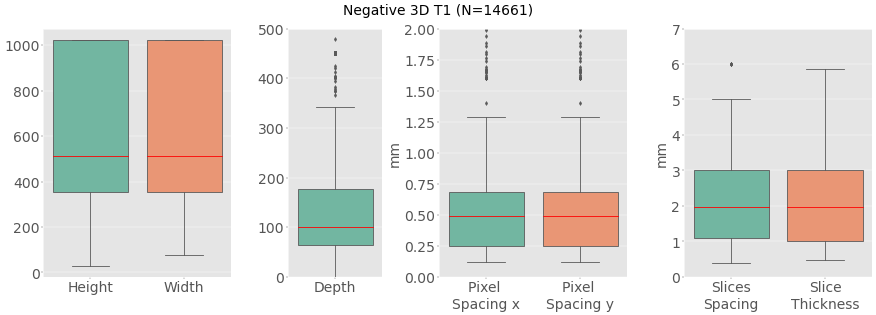

In [5]:
df_neg_3dt1 = dfc[(dfc.Sequence=='t1') & (dfc.MRAcquisitionType=='3D') & (dfc.Positive==0)]
fig, ax = plt.subplots(1,4, figsize=(22,8),gridspec_kw={'width_ratios': [2, 1,2,2]})
fig, _ = svis.create_boxplot(df_neg_3dt1[['Rows', 'Columns',]], 
    data_labels=["Height", "Width", ], 
    kwargs={'xlabel':'',},
    fig=fig, ax=ax[0])
svis.create_boxplot(df_neg_3dt1[['NumberOfSlices', ]], 
    data_labels=["Depth", ], 
    kwargs={'xlabel':'','yrange':(0,500)},
    fig=fig, ax=ax[1])
svis.create_boxplot(df_neg_3dt1[['RowSpacing', 'ColumnSpacing',]], 
    data_labels=["Pixel \nSpacing x", "Pixel \nSpacing y",], 
    kwargs={'xlabel':'','ylabel':'mm','yrange':(0,2)},
    fig=fig, ax=ax[2])
svis.create_boxplot(df_neg_3dt1[[ 'SpacingBetweenSlices','SliceThickness' ]], 
    data_labels=["Slices\nSpacing","Slice\nThickness" ], 
    kwargs={'xlabel':'','ylabel':'mm','yrange':(0,7)},
    fig=fig, ax=ax[3])
fig.suptitle(f"Negative 3D T1 (N={df_neg_3dt1.PatientID.nunique()})", fontsize=25)
fig.tight_layout()
fig.savefig(join(fig_dir, 't1', 'box_plot_neg_3dt1.png'))

In [6]:
dfc[dfc.Positive==1].PatientID.nunique()

786

In [7]:
df_volume_dir = pd.read_csv(join(table_dir, 'series_directories.csv'))
volume_dir_dic = pd.Series(
    df_volume_dir.Directory.values, index=df_volume_dir.SeriesInstanceUID)\
        .to_dict()

## 3d vs 2d data

In [8]:
df_3d = dfc[dfc.MRAcquisitionType=='3D']
df_2d = dfc[dfc.MRAcquisitionType=='2D']
df_3d[['SeriesDescription', 'PatientID', 'SeriesInstanceUID']].to_csv(join(base_dir,'data','temp','3d.csv'), index=False)
from scipy import stats
x = df_3d.NumberOfSlices
df_3d_rm_outliers = df_3d[x.between(x.quantile(.5), x.quantile(.95))]
nos_3d_min = df_3d_rm_outliers.NumberOfSlices.min()
print(nos_3d_min)

100.0


count    53955.000000
mean       126.538578
std         96.277807
min          0.000000
25%         67.000000
50%        100.000000
75%        176.000000
max       5184.000000
Name: NumberOfSlices, dtype: float64

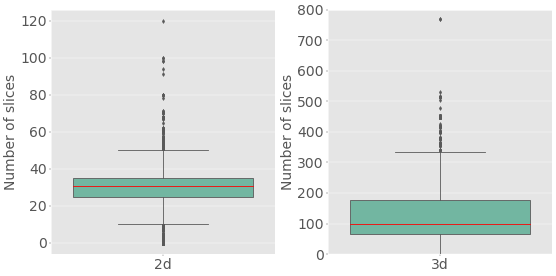

In [14]:
fig, ax = plt.subplots(1,2, figsize=(14,7) )
svis.create_boxplot(np.array(df_2d.NumberOfSlices), data_labels=['2d'], fig=fig, ax=ax[0])
svis.create_boxplot(np.array(df_3d.NumberOfSlices), data_labels=['3d'], fig=fig, ax=ax[1],
    kwargs={'yrange':(0,800)})
for a in ax:
    a.set_ylabel('Number of slices')
fig.tight_layout()
df_3d.NumberOfSlices.describe()

In [15]:
# Lists of relevant patients
ls_t1_pp = np.loadtxt("D:\Thesis\Cobra\cobra\data\patient_groups\\t1_pre_post.txt", dtype=str)
ls_t1_post = np.loadtxt("D:\Thesis\Cobra\cobra\data\patient_groups\\t1_post.txt", dtype=str)
#ls_t1_pos = np.loadtxt("D:\Thesis\Cobra\cobra\data\patient_groups\\t1_pos.txt", dtype=str)
ls_t1_neg = np.loadtxt("D:\Thesis\Cobra\cobra\data\patient_groups\\t1_neg.txt", dtype=str)
ls_t1_ppp = list(set(ls_t1_pp).union(set(ls_t1_post)))

In [16]:
df_t1_all = dfc[dfc.Sequence=='t1']
df_pp = dfc[(dfc.PatientID.isin(ls_t1_pp)) & (dfc.Sequence=='t1')]
df_pp_3d = dfc[(dfc.PatientID.isin(ls_t1_pp)) & (dfc.Sequence=='t1') \
    & (dfc.MRAcquisitionType=='3D') & (dfc.NumberOfSlices>50)]
df_post = dfc[(dfc.PatientID.isin(ls_t1_post)) & (dfc.Sequence=='t1')]

# Merge number of slices df with dfc and save

In [9]:
#present_ids = dfc[~dfc.NumberOfSlices.isna()].SeriesInstanceUID.unique()
#df_flair_missing = df_flair_all[~df_flair_all.SeriesInstanceUID.isin(present_ids)]

In [10]:
#utils.save_nscans_to_txt(df_flair_missing, 
#        f"{base_dir}/data/temp/flair_n_slices.txt", 'Y:', 'G:\\')

In [11]:
#df_flair_nos = pd.read_csv(f"{base_dir}/data/temp/flair_n_slices.txt", header=None, 
#    names=['SeriesInstanceUID','NumberOfSlices'])

In [19]:
#df_all = pd.read_csv(join(table_dir, 't1','all.csv'), index_col=0)
#dfc = pd.merge(dfc, df_all[['SeriesInstanceUID', 'NumberOfSlices']], on='SeriesInstanceUID', how='left')
#dfc = dfc.rename(columns={'xPixelSpacing':'RowSpacing','yPixelSpacing':'ColumnSpacing'})
#dfc.loc[dfc.NumberOfSlices.isna(), 'NumberOfSlices'] = dfc.merge(
#    df_flair_nos, how='left', on='SeriesInstanceUID')['NumberOfSlices_y']
#dfc.to_csv(f"{table_dir}/neg_pos_clean.csv", index=False, header=True)

# Create Box plots

## FLAIR

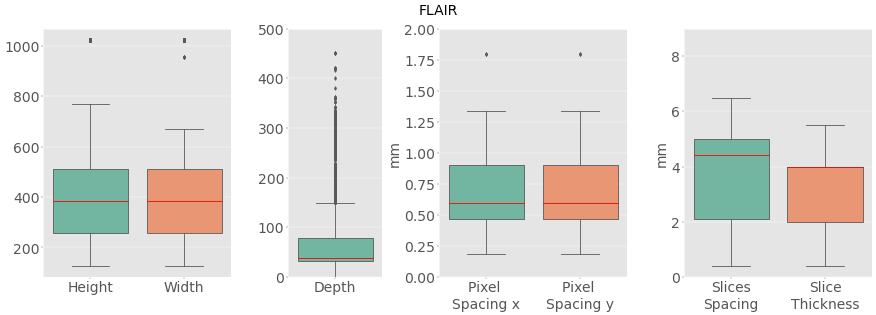

In [17]:
df_flair_all = dfc[dfc.Sequence=='flair']
fig, ax = plt.subplots(1,4, figsize=(22,8),gridspec_kw={'width_ratios': [2, 1,2,2]})
fig, _ = svis.create_boxplot(df_flair_all[['Rows', 'Columns',]], 
    data_labels=["Height", "Width", ], 
    kwargs={'xlabel':'',},
    fig=fig, ax=ax[0])
svis.create_boxplot(df_flair_all[['NumberOfSlices', ]], 
    data_labels=["Depth", ], 
    kwargs={'xlabel':'','yrange':(0,500)},
    fig=fig, ax=ax[1])
svis.create_boxplot(df_flair_all[['RowSpacing', 'ColumnSpacing',]], 
    data_labels=["Pixel \nSpacing x", "Pixel \nSpacing y",], 
    kwargs={'xlabel':'','ylabel':'mm','yrange':(0,2)},
    fig=fig, ax=ax[2])
svis.create_boxplot(df_flair_all[[ 'SpacingBetweenSlices','SliceThickness' ]], 
    data_labels=["Slices\nSpacing","Slice\nThickness" ], 
    kwargs={'xlabel':'','ylabel':'mm','yrange':(0,9)},
    fig=fig, ax=ax[3])
fig.suptitle("FLAIR", fontsize=25)
fig.tight_layout()
fig.savefig(join(fig_dir, 'flair', 'dimension_box_plot_flair_all.png'))

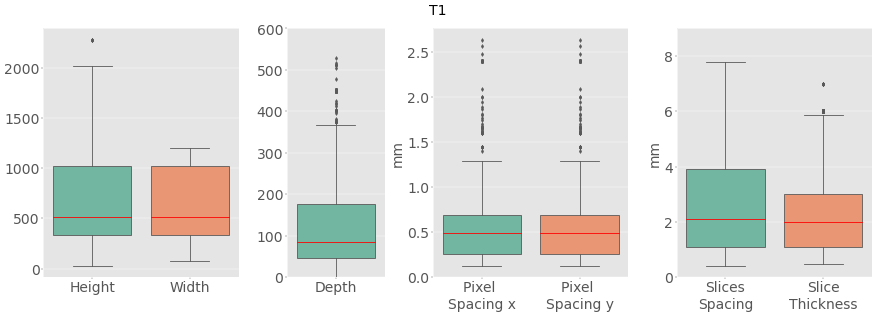

In [35]:
fig, ax = plt.subplots(1,4, figsize=(22,8),gridspec_kw={'width_ratios': [2, 1,2,2]})
fig, _ = svis.create_boxplot(df_t1_all[['Rows', 'Columns',]], 
    data_labels=["Height", "Width", ], 
    kwargs={'xlabel':'',},
    fig=fig, ax=ax[0])
svis.create_boxplot(df_t1_all[['NumberOfSlices', ]], 
    data_labels=["Depth", ], 
    kwargs={'xlabel':'','yrange':(0,600)},
    fig=fig, ax=ax[1])
svis.create_boxplot(df_t1_all[['RowSpacing', 'ColumnSpacing',]], 
    data_labels=["Pixel \nSpacing x", "Pixel \nSpacing y",], 
    kwargs={'xlabel':'','ylabel':'mm',},
    fig=fig, ax=ax[2])
svis.create_boxplot(df_t1_all[[ 'SpacingBetweenSlices','SliceThickness' ]], 
    data_labels=["Slices\nSpacing","Slice\nThickness" ], 
    kwargs={'xlabel':'','ylabel':'mm','yrange':(0,9)},
    fig=fig, ax=ax[3])
fig.suptitle("T1", fontsize=25)
fig.tight_layout()
fig.savefig(join(fig_dir, 't1', 'dimension_box_plot_t1all.png'))

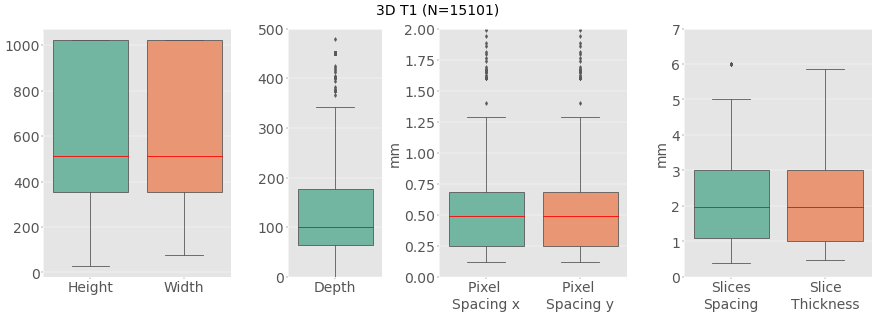

In [12]:

df_3dt1 = dfc[(dfc.Sequence=='t1') & (dfc.MRAcquisitionType=='3D')]
fig, ax = plt.subplots(1,4, figsize=(22,8),gridspec_kw={'width_ratios': [2, 1,2,2]})
fig, _ = svis.create_boxplot(df_3dt1[['Rows', 'Columns',]], 
    data_labels=["Height", "Width", ], 
    kwargs={'xlabel':'',},
    fig=fig, ax=ax[0])
svis.create_boxplot(df_3dt1[['NumberOfSlices', ]], 
    data_labels=["Depth", ], 
    kwargs={'xlabel':'','yrange':(0,500)},
    fig=fig, ax=ax[1])
svis.create_boxplot(df_3dt1[['RowSpacing', 'ColumnSpacing',]], 
    data_labels=["Pixel \nSpacing x", "Pixel \nSpacing y",], 
    kwargs={'xlabel':'','ylabel':'mm','yrange':(0,2)},
    fig=fig, ax=ax[2])
svis.create_boxplot(df_3dt1[[ 'SpacingBetweenSlices','SliceThickness' ]], 
    data_labels=["Slices\nSpacing","Slice\nThickness" ], 
    kwargs={'xlabel':'','ylabel':'mm','yrange':(0,7)},
    fig=fig, ax=ax[3])
fig.suptitle(f"3D T1 (N={df_3dt1.PatientID.nunique()})", fontsize=25)
fig.tight_layout()
fig.savefig(join(fig_dir, 't1', 'box_plot_3dt1.png'))

## PP patients with sufficient slices

In [49]:
df_3d.NumberOfSlices.describe()

count    53955.000000
mean       126.538578
std         96.277807
min          0.000000
25%         67.000000
50%        100.000000
75%        176.000000
max       5184.000000
Name: NumberOfSlices, dtype: float64

Volumes with more than 64 slices will be counted as 3d.

In [94]:
df_t1_pp_3d_0 = dfc[(dfc.PatientID.isin(ls_t1_pp)) & (dfc.NumberOfSlices>=64) \
    & (dfc.Sequence=='t1')]

print(f"{df_t1_pp_3d_0.PatientID.nunique()} patients with 3d")
ls_pat_pre_temp = df_t1_pp_3d_0[(df_t1_pp_3d_0.days_since_test<=-30)].PatientID.unique()
print(f"{len(ls_pat_pre_temp)} patients with 3d before disease")
ls_pat_pp_temp = df_t1_pp_3d_0[(df_t1_pp_3d_0.PatientID.isin(ls_pat_pre_temp)) \
    & (df_t1_pp_3d_0.days_since_test>=-3)].PatientID.unique()
print(f"{len(ls_pat_pp_temp)} patients with 3D T1 scans before and after pos. test")
df_t1_pp_3d = df_t1_pp_3d_0[df_t1_pp_3d_0.PatientID.isin(ls_pat_pp_temp)]
#save df
df_t1_pp_3d.to_csv(join(table_dir, 't1','t1_pc_3d.csv'), index=False)
#save list of patient
np.savetxt(join(base_dir, 'data', 't1_longitudinal','pos_t1_3d.txt'),
        df_t1_pp_3d.PatientID.unique(), delimiter=" ", fmt="%s")
print(f"Total number of scans: {len(df_t1_pp_3d)}")

31 patients with 3d
29 patients with 3d before disease
24 patients with 3D T1 scans before and after pos. test
Total number of scans: 224


In [89]:
df_t1_pp_3d.SpacingBetweenSlices.describe()

count    169.000000
mean       1.484627
std        0.617173
min        0.800000
25%        0.900000
50%        1.100000
75%        2.000000
max        3.000000
Name: SpacingBetweenSlices, dtype: float64

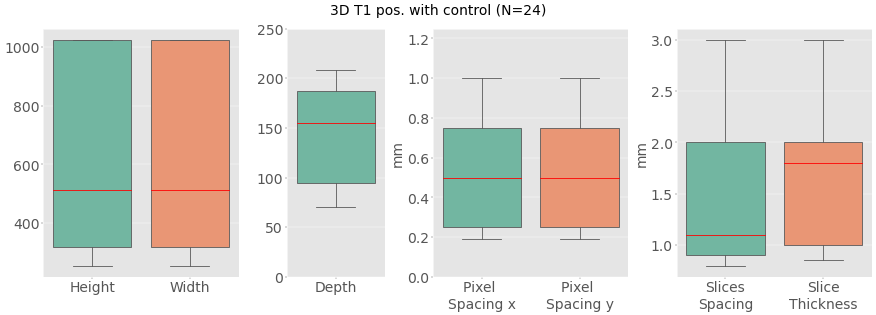

In [77]:
fig, ax = plt.subplots(1,4, figsize=(22,8),gridspec_kw={'width_ratios': [2, 1,2,2]})
fig, _ = svis.create_boxplot(df_t1_pp_3d[['Rows', 'Columns',]], 
    data_labels=["Height", "Width", ], 
    kwargs={'xlabel':'',},
    fig=fig, ax=ax[0])
svis.create_boxplot(df_t1_pp_3d[['NumberOfSlices', ]], 
    data_labels=["Depth", ], 
    kwargs={'xlabel':'','yrange':(0,250)},
    fig=fig, ax=ax[1])
svis.create_boxplot(df_t1_pp_3d[['RowSpacing', 'ColumnSpacing',]], 
    data_labels=["Pixel \nSpacing x", "Pixel \nSpacing y",], 
    kwargs={'xlabel':'','ylabel':'mm','yrange':(0,1.25)},
    fig=fig, ax=ax[2])
svis.create_boxplot(df_t1_pp_3d[[ 'SpacingBetweenSlices','SliceThickness' ]], 
    data_labels=["Slices\nSpacing","Slice\nThickness" ], 
    kwargs={'xlabel':'','ylabel':'mm',},
    fig=fig, ax=ax[3])
fig.suptitle(f"3D T1 pos. with control (N={df_t1_pp_3d.PatientID.nunique()})", fontsize=25)
fig.tight_layout()
fig.savefig(join(fig_dir, 't1', 'dimension_box_plot_3dt1pp.png'))

# Identify tumor patients

In [7]:
tumor_patient_tag = ['82f44e', '06c4453', '244a7d', '85b117f',
                        ]
tumor_patient_list = []
for tag in tumor_patient_tag:
    tumor_patient_list.append(
        dfc[dfc.PatientID.str.startswith(tag)].PatientID.unique()[0])

In [9]:
df_t1_pc = dfc[dfc.PatientID.isin(tumor_patient_list)]

In [13]:
df_t1_pc[df_t1_pc.Sequence=='t1'][['SeriesInstanceUID', 'PatientID']].to_csv(
    'D:\Thesis\Cobra\cobra\\figs\sp\T1\cancer.csv')

# Save list of negative patients with t1 3d

In [25]:
df_neg_3d_t1 = dfc[(dfc.Positive==0) & (dfc.Sequence=='t1') & (dfc.MRAcquisitionType=='3D') & (dfc.NumberOfSlices>=64)] 
#at least 2 scans
ls_neg_3d_t1 = df_neg_3d_t1.groupby('PatientID').size()[df_neg_3d_t1.groupby('PatientID').size()>=2].index.to_list()
df_neg_3d_t1 = df_neg_3d_t1[df_neg_3d_t1.PatientID.isin(ls_neg_3d_t1)]
np.savetxt(join(base_dir, 'data', 't1_longitudinal','neg_t1_3d.txt'),
        df_neg_3d_t1.PatientID.unique(), delimiter=" ", fmt="%s")

In [26]:
# Positive patients with at least 2 neg scans
df_pos_3d_t1_pre = dfc[(dfc.Positive==1) & (dfc.Sequence=='t1') & (dfc.MRAcquisitionType=='3D') & (dfc.NumberOfSlices>=64) &
                    (dfc.days_since_test<=-30)] 
#at least 2 scans
ls_pos_3d_t1_pre = df_pos_3d_t1_pre.groupby('PatientID').size()[df_pos_3d_t1_pre.groupby('PatientID').size()>=2].index.to_list()
df_pos_3d_t1_pre = df_pos_3d_t1_pre[df_pos_3d_t1_pre.PatientID.isin(ls_pos_3d_t1_pre)]
np.savetxt(join(base_dir, 'data', 't1_longitudinal','pos_t1_3d_pre.txt'),
       df_pos_3d_t1_pre.PatientID.unique(), delimiter=" ", fmt="%s")

# Get list of t1 pos/control scans

In [189]:
arr_t1_neg = dfc[(dfc.Sequence=='t1') & (dfc.Positive==0)].PatientID.unique()
np.savetxt("D:\Thesis\Cobra\cobra\data\patient_groups\\t1_neg.txt", arr_t1_neg,
        delimiter=" ", fmt="%s")

In [190]:
arr_t1_all = dfc[dfc.Sequence=='t1'].PatientID.unique()
np.savetxt("D:\Thesis\Cobra\cobra\data\patient_groups\\t1_all.txt", arr_t1_all,
        delimiter=" ", fmt="%s")

In [10]:
ls_t1_pos = dfc[(dfc.Sequence=='t1') & (dfc.Positive==1)].PatientID.unique()
ls_t1_pos_rest = list((set(ls_t1_pos)-set(ls_t1_post))-set(ls_t1_pp))
np.savetxt("D:\Thesis\Cobra\cobra\data\patient_groups\\t1_pos_rest.txt", np.array(ls_t1_pos_rest),
    delimiter=" ", fmt="%s")

In [16]:
arr_t1_pos_rest_suid = np.array(dfc[(dfc.Sequence=='t1') & (dfc.PatientID.isin(ls_t1_pos_rest))].SeriesInstanceUID.unique())
np.savetxt("D:\Thesis\Cobra\cobra\data\patient_groups\\t1_pos_rest_suid.txt", arr_t1_pos_rest_suid,
    delimiter=" ", fmt="%s")